In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer,BertModel
from tqdm import tqdm
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
#round1
df1=pd.read_csv('Data/xhs/#人机恋.csv')
df2=pd.read_csv('Data/xhs/#ai男友.csv')
df3=pd.read_csv('Data/xhs/#ai聊天.csv')
df4=pd.read_csv('Data/xhs/#ai情感陪伴.csv')
df5=pd.read_csv('Data/xhs/#虚拟男友.csv')

#round2
df6=pd.read_csv('Data/xhs/#ai女友.csv')
df7=pd.read_csv('Data/xhs/#虚拟女友.csv')
df8=pd.read_csv('Data/xhs/#ai恋爱.csv')
df9=pd.read_csv('Data/xhs/#虚拟恋人.csv')
df10=pd.read_csv('Data/xhs/#ai陪伴.csv')

df_glow=pd.read_csv('Data/xhs/#glow.csv')
df_xingye=pd.read_csv('Data/xhs/#星野.csv')
df_dan=pd.read_csv('Data/xhs/#dan模式.csv')

In [8]:
# dfs = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
dfs=[df_glow,df_xingye,df_dan]
combined_df = pd.concat([df.drop_duplicates(subset=['note_id']) for df in dfs], ignore_index=True)
combined_df.shape

(643, 20)

In [9]:
combined_df['tag_list'] = combined_df['tag_list'].str.split(',')
combined_df['tag_list'] = combined_df['tag_list'].apply(
    lambda tags: [tag.strip().lower() for tag in tags] if isinstance(tags, list) else []
)
dfTag = pd.DataFrame(combined_df[['note_id', 'tag_list']]).dropna(subset=['tag_list'])# 去掉那些没有tag的部分
dfTag.head()
tag_pairs = dfTag.explode('tag_list').groupby('note_id')['tag_list'].apply(lambda x: [(a, b) for a in x for b in x if a != b])
tag_co_occurrences = pd.DataFrame(tag_pairs.explode().tolist(), columns=['tag1', 'tag2']).groupby(['tag1', 'tag2']).size().reset_index(name='weight')
# 按weight倒序排列并打印
tag_co_occurrences = tag_co_occurrences.sort_values(by='weight', ascending=False)
print(tag_co_occurrences)

          tag1          tag2  weight
2428      glow            ai     145
133         ai          glow     145
13537      筑梦岛          glow     128
2614      glow           筑梦岛     128
2445      glow          ai聊天     127
...        ...           ...     ...
5921   北海道亲子滑雪        北海道亲子游       1
5922   北海道亲子滑雪         北海道旅游       1
5924   北海道亲子滑雪      北海道星野渡假村       1
5926   北海道亲子滑雪  北海道滑雪clubmed       1
15571      麦当劳       chatgpt       1

[15572 rows x 3 columns]


各关键词文档搜索结果tag之间的关系

[145, 145, 128, 128, 127, 127, 119, 119, 4, 4, 3, 3, 1, 1, 59, 59, 55, 55, 53, 53, 53, 53, 48, 48, 35, 35, 14, 14, 7, 7, 2, 2, 56, 56, 43, 43, 2, 2, 1, 1, 1, 1, 62, 62, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 98, 98, 66, 66, 16, 16, 11, 11, 77, 77, 22, 22, 10, 10, 19, 19, 13, 13, 3, 3]


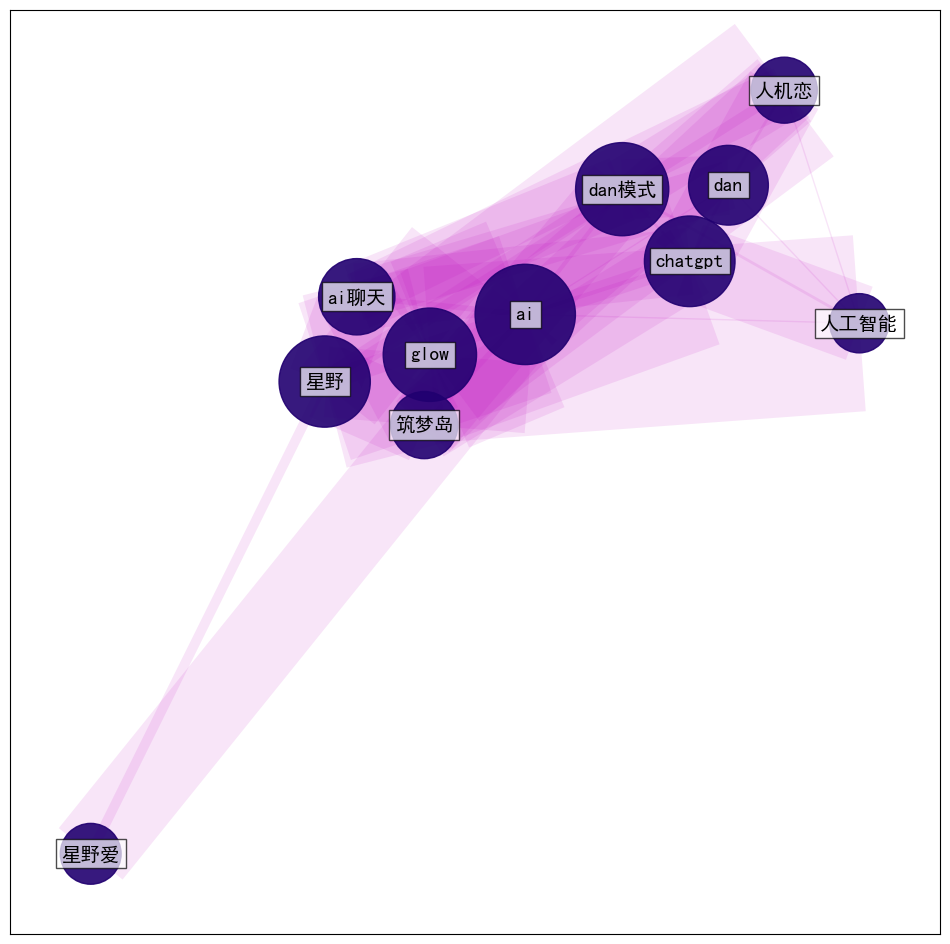

In [10]:
# 创建 MultiGraph
plt.rcParams['font.sans-serif'] = 'SimHei'
Gn = nx.MultiGraph()

for _, row in tag_co_occurrences.iterrows():
    Gn.add_edge(row['tag1'], row['tag2'], weight=row['weight'])

GAll=nx.Graph(Gn)#存档

#去掉‘偶然性’引用的tag
degrees = dict(Gn.degree())
nodes_to_remove = [node for node, degree in degrees.items() if degree < 180]
Gn.remove_nodes_from(nodes_to_remove)

#更换图片样式
H = nx.Graph(Gn)
# print(H.edges)
edgewidth = list(nx.get_edge_attributes(Gn, 'weight').values())
print(edgewidth)
# 计算每个节点的度
# node_degrees = dict(H.degree())
# 设置节点大小为度数
node_sizes = [degrees[node]*10 for node in Gn.nodes()]
# # 绘制网络图
pos = nx.spring_layout(H)
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(H, pos, alpha=0.1, width=edgewidth, edge_color="m")
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(H, pos, font_size=14, bbox=label_options)
plt.show()

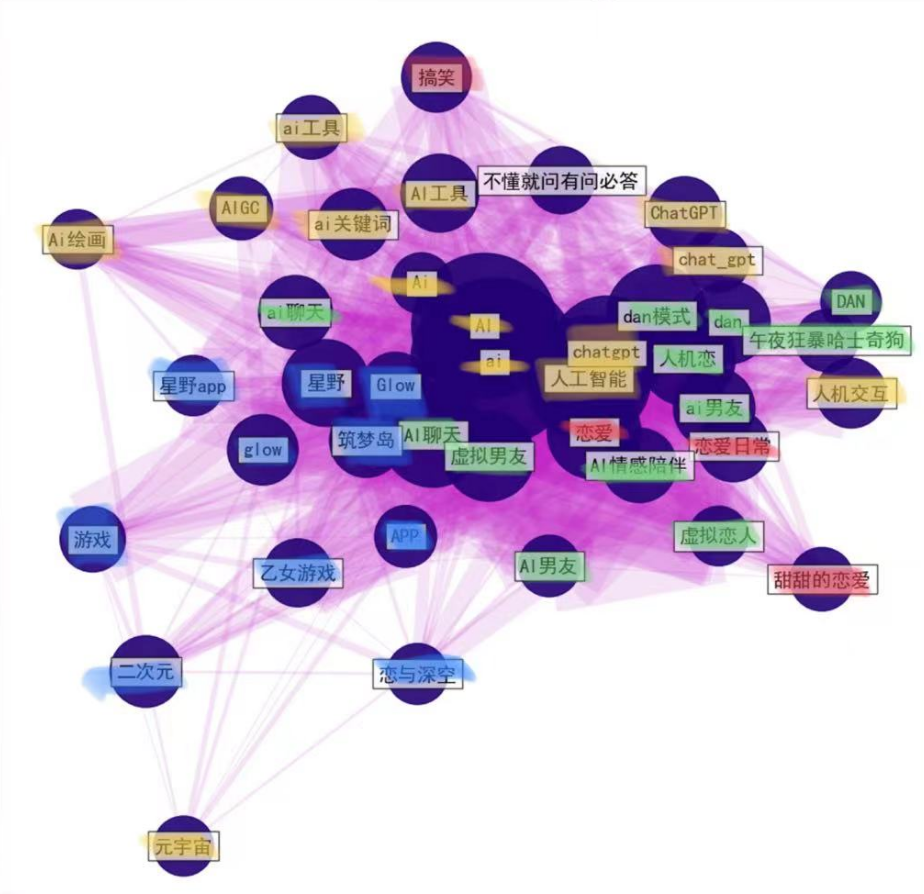

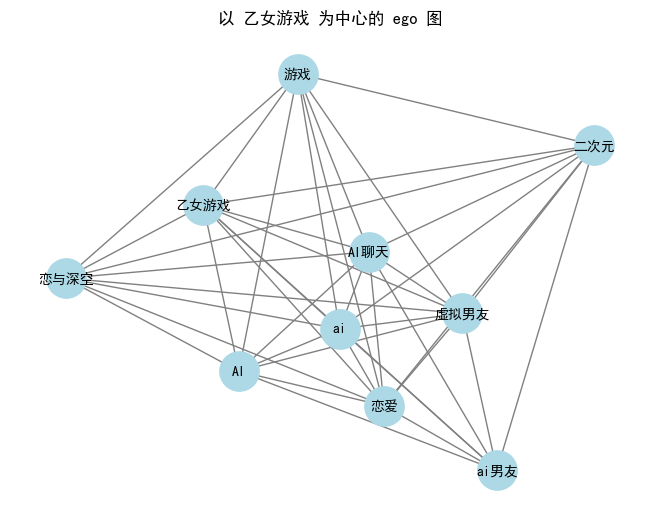

In [6]:
# 选择中心节点
ego_node = '乙女游戏'

# 创建以 ego_node 为中心的 ego 图
ego_graph = nx.ego_graph(GAll, ego_node)

#去掉‘偶然性’引用的tag
degrees = dict(ego_graph.degree())
nodes_to_remove = [node for node, degree in degrees.items() if degree < 30]
ego_graph.remove_nodes_from(nodes_to_remove)


pos = nx.spring_layout(ego_graph)
nx.draw(ego_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, font_size=10)
plt.title(f'以 {ego_node} 为中心的 ego 图')

plt.show()

**社區劃分 Girvan-Newman算法**  
网络图中，连接较为紧密的部分可以被看成一个社区。每个社区内部节点之间有较为紧密的连接，而在两个社区间连接则较为稀疏。社区发现就是找到给定网络图所包含的一个个社区的过程。

Girvan-Newman 算法即是一种基于介数的社区发现算法，其基本思想是根据 **边介数中心性（edge betweenness）** 从大到小的顺序不断地将边从网络中移除直到整个网络分解为各个社区。因此，Girvan-Newman 算法实际上是一种分裂方法。

Girvan-Newman 算法的基本流程如下：  
（1）计算网络中所有边的边介数；  
（2）找到边介数最高的边并将它从网络中移除；   
（3）重复步骤 2，直到每个节点成为一个独立的社区为止，即网络中没有边存在。  

**边介数中心性**是一种衡量图中边的重要性的指标。它反映了一条边在**最短路径**上出现的次数。

具体来说,edge betweenness 计算方法如下:

对于图中的每对节点 i 和 j，计算从 i 到 j 的所有最短路径  
对于图中的每条边 e，计算有多少条最短路径经过该边  
每条边的 betweenness 值就是经过它的最短路径的数量  
边介数中心性值较高的边,意味着它在图中扮演了重要的 **"桥梁"** 角色,在连接整个网络中的不同部分时起到关键作用。

相比于节点中心性,边介数中心性可以帮助我们识别图中的关键联系,而不仅仅是关键节点。

In [18]:
import itertools
comp = nx.algorithms.community.girvan_newman(GAll)
k = 3#想要的社区数量的上限
limited = list(itertools.takewhile(lambda c: len(c) <= k, comp))#使用takewhile函数从comp生成器中取出社区数量小于等于7的社区划分结果
# print(list(limited)[0])
# communities = list(limited)[-1]